<a href="https://colab.research.google.com/github/marcofoiss/ML-Project/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Logistic Regression from scratch**

In [ ]:
import numpy as np
import pandas as pd
import re
from collections import Counter


# Preprocessing Functions
def tokenize(text):
    text = text.lower() # Converte tutto il testo in minuscolo
    text = re.sub(r'[^a-z\s]', '', text) # Rimuove punteggiatura e numeri
    return text.split() # Divide il testo in una lista di parole

def build_vocab(texts, max_vocab_size=5000):
    counter = Counter() # Crea un oggetto Counter (da collections) per contare le occorrenze delle parole
    for text in texts:
        tokens = tokenize(text)
        counter.update(tokens)
    vocab = {word: i for i, (word, _) in enumerate(counter.most_common(max_vocab_size))} # Seleziona le max_vocab_size parole più frequenti e assegna un indice a ciascuna
    return vocab

def vectorize(text, vocab):
    vec = [0] * len(vocab) # Inizializza un vettore di zeri di lunghezza pari al vocabolario
    for word in tokenize(text): # Per ogni parola nel testo, se è nel vocabolario, incrementa la posizione corrispondente nel vettore
        if word in vocab:
            vec[vocab[word]] += 1 # Esempio: se "fake" è la parola 10 nel vocabolario, vec[10] += 1.
    return vec


# Logistic Regression Model
class LogisticRegressionScratch: # Definisce una nuova classe che implementa un modello di regressione logistica "fatto a mano" (scratch)
    def __init__(self, input_dim, lr=0.01, epochs=1000): # Metodo costruttore della classe, chiamato quando crei un'istanza
    # input_dim: numero di feature in input
    # lr: learning rate (passo di aggiornamento dei pesi)
    # epochs: numero di iterazioni dell'allenamento
        self.w = np.zeros(input_dim) # Inizializza i pesi w come un vettore di zeri, con dimensione uguale al numero di feature
        self.b = 0
        self.lr = lr
        self.epochs = epochs
        self.losses = [] # Inizializza una lista vuota per salvare i valori della funzione di loss durante il training

    def sigmoid(self, z):  # Definisce una funzione interna alla classe per calcolare la funzione sigmoide, che trasforma un valore reale in un valore tra 0 e 1 (probabilità)
      z = np.clip(z, -500, 500)  # Limita i valori di z fra -500 e 500 per evitare problemi numerici di overflow con l’esponenziale (np.exp)
      return 1 / (1 + np.exp(-z)) # Calcola la funzione sigmoide: 1 / (1 + exp(-z)), la quale serve per ottenere le probabilità predette da qualsiasi input lineare.

    def predict_prob(self, X): # Metodo che calcola la probabilità che l’input X appartenga alla classe 1.
        return self.sigmoid(np.dot(X, self.w) + self.b) # Calcola la combinazione lineare X*w + b e passa il risultato alla funzione sigmoide per ottenere la probabilità.

    def predict(self, X): # Metodo per ottenere le classi predette (0 o 1) da input X.
        return (self.predict_prob(X) >= 0.5).astype(int) # Calcola la probabilità e converte in etichetta 0 o 1 usando soglia 0.5 (se la probabilità è ≥ 0.5 predice 1, altrimenti 0)

    def fit(self, X, y): # Metodo per allenare il modello usando i dati X (input) e y (etichette vere)
        for epoch in range(self.epochs): # Ciclo di training che si ripete per epochs volte
            y_hat = self.predict_prob(X) # Calcola le probabilità predette dal modello per tutti gli esempi X.
            error = y_hat - y # Calcola l’errore come differenza tra probabilità predette e valori veri (y).

            dw = np.dot(X.T, error) / len(y) # Calcola il gradiente della loss rispetto ai pesi  (media dei prodotti tra errore e input)
            db = np.mean(error) # Calcola il gradiente della loss rispetto al bias b (media degli errori)

            # Aggiorna pesi e bias spostandoli nella direzione opposta al gradiente, il passo è modulato dal learning rate lr
            self.w -= self.lr * dw
            self.b -= self.lr * db


            loss = -np.mean(y * np.log(y_hat + 1e-8) + (1 - y) * np.log(1 - y_hat + 1e-8)) # Calcola la cross-entropy, una misura di quanto sono sbagliate le predizioni, il 1e-8 evita log(0).
            self.losses.append(loss)  # Salva il loss ad ogni epoca

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")


# Evaluation Function
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


if __name__ == "__main__":

    # Carica i dataset Fake.csv e True.csv, aggiungendo una colonna label (0 per fake, 1 per real).
    df_fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fake.csv", on_bad_lines='skip')
    df_fake["label"] = 0
    df_real = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/True.csv", on_bad_lines='skip')
    df_real["label"] = 1

    # Serve ad unire, mescolare casualmente e reindicizzare
    # sample(frac=1) → Prende un campione casuale del 100% delle righe, quindi mescola casualmente tutte le righe del DataFrame unito.
    # Dopo il mescolamento, l’indice è disordinato (es: [10, 3, 45, ...]), .reset_index(drop=True) reimposta l’indice da zero (0, 1, 2, ...) e scarta quello vecchio (drop=True).
    data = pd.concat([df_fake, df_real]).sample(frac=1).reset_index(drop=True)

    # data["text"] → prende la colonna text dal DataFrame data (cioè i testi delle notizie).
    # .fillna("") → sostituisce eventuali valori NaN (mancanti) con una stringa vuota "", per evitare errori nel preprocessing.
    # .tolist() → converte la colonna (che è una Series) in una lista di stringhe.
    # Risultato: una lista texts contenente tutti i testi delle notizie.
    texts = data["text"].fillna("").tolist()

    # Estrae la colonna label, che contiene le etichette (es: 0 per fake, 1 per real).
    # .values la converte in un array NumPy, utile per modelli ML.
    # Risultato: un array labels con le etichette associate a ciascun testo.
    labels = data["label"].values

    # Costruisce il vocabolario a partire dalla lista di testi delle notizie
    vocab = build_vocab(texts, max_vocab_size=2000)
    print(f"Vocabulary size: {len(vocab)}")

    # Cicla su tutti i testi nella lista texts e applica la funzione vectorize a ciascuno
    # Esempio:
    # texts = ["fake news", "real news", "fake fake"]
    # vectorize(text, vocab)
    # vocab = {'fake': 0, 'real': 1, 'news': 2}
    # texts = ["fake news", "real news", "fake fake"]
    # Inizializza un vettore con zeri: [0, 0, 0], poi per ogni parola:
    # "fake" è nel vocabolario alla posizione 0 → incremento vec[0] += 1 → [1, 0, 0]
    # "news" è alla posizione 2 → incremento vec[2] += 1 → [1, 0, 1]
    # vectorize("fake news", vocab) → [1, 0, 1]
    # vectorize("real news", vocab) → [0, 1, 1]
    # vectorize("fake fake", vocab) → [2, 0, 0]
    # X = [[1 0 1]
    #      [0 1 1]
    #      [2 0 0]]
    X = np.array([vectorize(text, vocab) for text in texts]) # Ogni riga rappresenta un testo, Ogni colonna rappresenta una parola del vocabolario, I valori sono le frequenze delle parole nel testo
    y = np.array(labels) # contiene le etichette corrispondenti (0 per fake, 1 per real)

    # Divide il dataset in → Training set: primi 80% dei dati |  Test set: ultimi 20% dei dati
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Training of the model
    print("Training")
    model = LogisticRegressionScratch(input_dim=X.shape[1], lr=0.1, epochs=300)
    model.fit(X_train, y_train)

    # Evaluation of the classification
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy(y_test, y_pred))

Vocabulary size: 2000
Training
Epoch 0, Loss: 0.6931
Epoch 100, Loss: 0.1872
Epoch 200, Loss: 0.1179
Accuracy: 0.9791759465478842



**Distribuzione fake vs real**

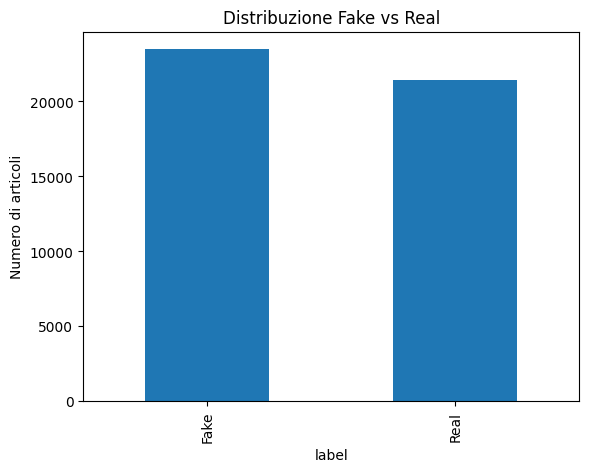

In [ ]:
import matplotlib.pyplot as plt

data['label'].value_counts().plot(kind='bar')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.ylabel('Numero di articoli')
plt.title('Distribuzione Fake vs Real')
plt.show()

**Matrice di Confusione**

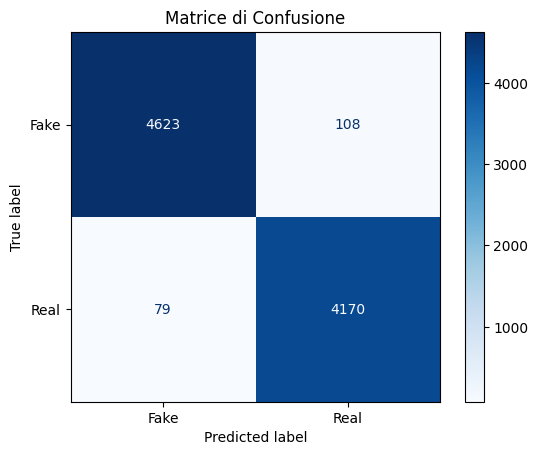

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Fake', 'Real']).plot(cmap='Blues')
plt.title('Matrice di Confusione')
plt.show()

**Andamento della loss function**

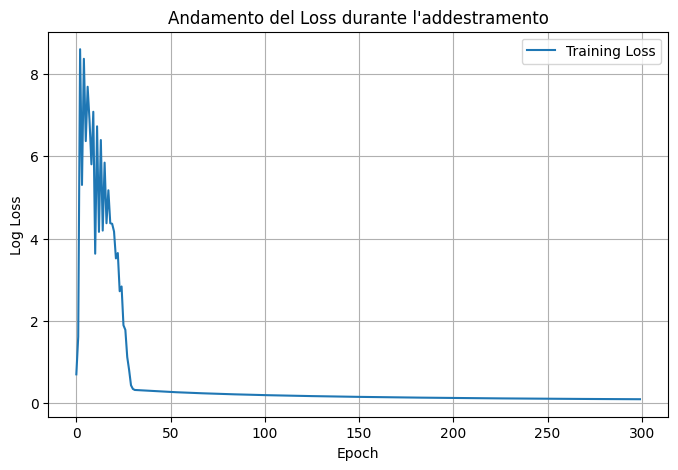

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(len(model.losses)), model.losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("Andamento del Loss durante l'addestramento")
plt.legend()
plt.grid(True)
plt.show()